In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/loans-data/loans_data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

# Ignore the resulting DataConversionWarning 
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Linux-5.15.65+-x86_64-with-debian-bullseye-sid
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
NumPy 1.21.6
SciPy 1.7.3
Scikit-Learn 1.0.2


# Scenario
We work for LendingClub which is a US peer-to-peer lending company, headquartered in San Francisco, California. This company loans to private individuals. Investors indicate how much money they want to make available and the system pools money from different investors and forwards this money to people who are looking for a loan. The people who take out a loan often have a low credit rating, which is why they do not get the loan in the classic way from a bank. Particularly risky loans receive an interest rate of over 14%. Such loans are classified internally as problem loans and require close attention from LendingClub.

Previously, a service provider calculated the interest rate for each loan. The services of the external provider are now to be taken over step by step by internal departments. This saves costs and makes the assessment more transparent for LendingClub.

## Goal
The task is to automatically classify the loans into problem loans and normal loans.

Loan data has been acquired from LendingClub official website and US state codes and their names acquired from Wikipedia.

![](https://m.bankingexchange.com/media/k2/items/cache/c852cd1706018952eef5203293178d22_XL.jpg?t=20170208_004958)

Image source: https://m.bankingexchange.com



# Gather Data

In [3]:
#Import regured modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# suppress scientific notation
np.set_printoptions(suppress=True) 
pd.options.display.float_format = '{:.6f}'.format

# Read Data
df = pd.read_csv('/kaggle/input/loans-data/loans_data.csv')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,id,issue_d,funded_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,title,zip_code,verification_status,purpose,total_acc,percent_bc_gt_75,total_bc_limit,revol_bal
0,36805548,Dec-2014,10400.000000,36 months,6.990000,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.000000,Credit card refinancing,937xx,Not Verified,credit_card,36.000000,14.300000,13000.000000,6133.000000
1,38098114,Dec-2014,15000.000000,60 months,12.390000,C,C1,MANAGEMENT,10+ years,RENT,78000.000000,Debt consolidation,235xx,Source Verified,debt_consolidation,17.000000,0.000000,10000.000000,138008.000000
2,37822187,Dec-2014,9600.000000,36 months,13.660000,C,C3,Admin Specialist,10+ years,RENT,69000.000000,Debt consolidation,077xx,Source Verified,debt_consolidation,44.000000,60.000000,21100.000000,16388.000000
3,37662224,Dec-2014,7650.000000,36 months,13.660000,C,C3,Technical Specialist,< 1 year,RENT,50000.000000,Debt consolidation,850xx,Source Verified,debt_consolidation,20.000000,100.000000,4900.000000,16822.000000
4,37842129,Dec-2014,21425.000000,60 months,15.590000,D,D1,Programming Analysis Supervisor,6 years,RENT,63800.000000,Credit card refinancing,658xx,Source Verified,credit_card,35.000000,100.000000,15000.000000,16374.000000


In [4]:
# Shape of the data 
print('Number of rows: ', df.shape[0])
print('Number of columns: ', df.shape[1])

Number of rows:  451671
Number of columns:  19


# Data Dictionary

In [5]:
# Import and read data dictionary to get familiar with data coumn names and their description.
import pandas as pd 
data_dict = pd.read_csv('/kaggle/input/d/iamamir/loans-data-dict/loans_data_dict.csv',index_col = 'Column number')
data_dict

,Column name,Data type,Description
Column number,,,
0,'id',Categorical,Identification number of the loan
1,'issue_d',Date (string),Year and month in which the loan was granted
2,'funded_amnt',Numerical(float),Amount lent in US dollars
3,'term',Numerical (int),number of repayment installments in months (3...
4,'int_rate',Numeric (float),interest rate
5,'grade',Categorical,Assigned grade of creditworthiness by externa...
6,'sub_grade',Categorical,Fine grade of the assigned grade on creditwor...
7,'emp_title',Categorical,Job title of the borrower at the start of the...
8,'emp_length',Categorical,(ordinal) Duration of the borrower's employme...


# Split Data For Hyperparameter Tuning

Before we start data analysis, we should always separate our data into a training, validation and testing data set. For the hyperparameter tuning of our model, we first divide data into train and validation data set. 

In [6]:
from sklearn.model_selection import train_test_split

# Split dataset to train and validation dataframe
df_train, df_val = train_test_split(df,test_size=0.3,random_state=0)

# For safe editing
df_train_org = df_train.copy()

In [7]:
df_train_org

,id,issue_d,funded_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,title,zip_code,verification_status,purpose,total_acc,percent_bc_gt_75,total_bc_limit,revol_bal
182824,13016316,Mar-2014,35000.000000,36 months,14.640000,C,C3,president,9 years,RENT,160000.000000,Debt consolidation,531xx,Source Verified,debt_consolidation,24.000000,25.000000,31200.000000,20328.000000
72179,27130037,Sep-2014,14400.000000,36 months,7.120000,A,A3,Employment Consultant,10+ years,MORTGAGE,35000.000000,Credit card refinancing,985xx,Not Verified,credit_card,26.000000,0.000000,97700.000000,14002.000000
81692,25216609,Sep-2014,15000.000000,36 months,10.990000,B,B3,President,1 year,MORTGAGE,175000.000000,Debt consolidation,950xx,Source Verified,debt_consolidation,14.000000,100.000000,500.000000,2571.000000
83169,25246069,Aug-2014,8000.000000,36 months,12.990000,C,C1,Manager,10+ years,RENT,40000.000000,Debt consolidation,124xx,Source Verified,debt_consolidation,29.000000,0.000000,3500.000000,4849.000000
256614,476062,Jan-2010,20000.000000,36 months,12.530000,B,B5,Memorial Sloan-Kettering Cancer Center,2 years,RENT,51000.000000,Returning To School,112xx,Not Verified,educational,15.000000,NaN,NaN,10695.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152315,16030773,May-2014,12600.000000,60 months,24.500000,F,F3,Heavy Mobile Equipment Mechanic,4 years,MORTGAGE,65000.000000,Home improvement,706xx,Source Verified,home_improvement,21.000000,66.700000,7800.000000,7012.000000
439107,1271976,May-2012,12650.000000,60 months,13.990000,C,C1,Robins AFB,6 years,MORTGAGE,48000.000000,Pay It ALL Off,310xx,Verified,debt_consolidation,25.000000,28.600000,12800.000000,17404.000000
117952,20079393,Jul-2014,8000.000000,36 months,8.390000,A,A5,Technician,10+ years,MORTGAGE,50000.000000,Home improvement,318xx,Not Verified,home_improvement,21.000000,0.000000,20000.000000,369.000000
435829,1306621,Jun-2012,21000.000000,60 months,17.990000,D,D2,Wells Fargo Insurance Services,2 years,MORTGAGE,82000.000000,Debt Consolidation Loan,087xx,Verified,credit_card,26.000000,60.000000,53892.000000,44009.000000


Let's edit train. To start, we create the target variable by creating a column named 'problem_loan'. It should contain a 1 if the loan has an interest rate of more than 14%, i.e. if 'int_rate' > 14. Otherwise it should contain 0.

In [8]:
# Create the target variable
mask=(df_train.loc[:,'int_rate'] > 14).astype('int8')
df_train.loc[:,'problem_loan']=mask
print('Number of Problem Loans in train data set: ',df_train.loc[:,'problem_loan'].sum())

Number of Problem Loans in train data set:  144189


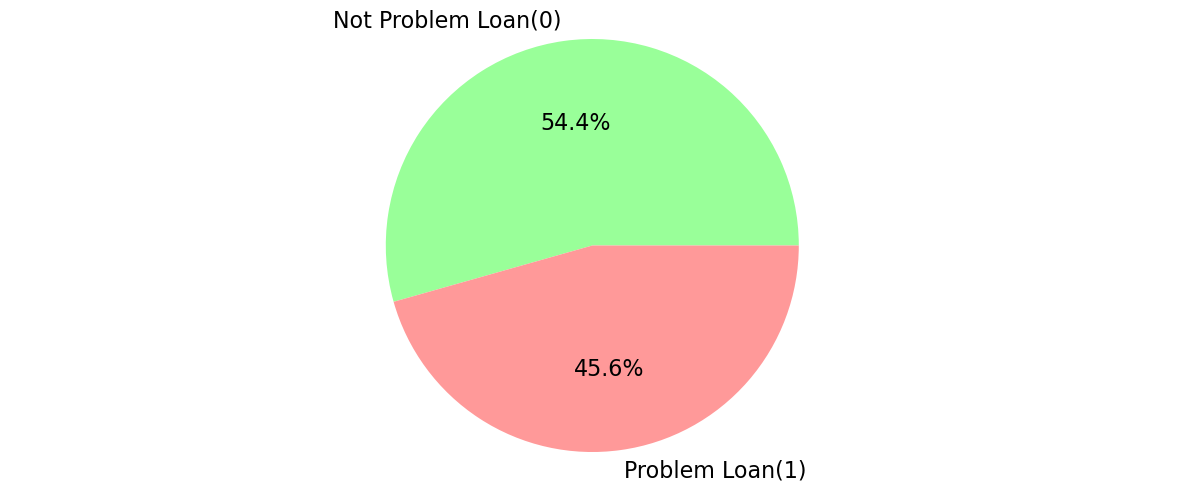

In [9]:
# Get an idea of target category: IsBadBuy
plt.figure(figsize=(15,6))
problem_loan_share = df_train["problem_loan"].value_counts()
mylabel=["Not Problem Loan(0)","Problem Loan(1)"]
colors = ['#99ff99','#ff9999']
plt.pie(problem_loan_share,
        labels=mylabel,autopct="%1.1f%%",colors=colors,
        textprops={'fontsize': 16})
plt.axis("equal");

In [10]:
# Check the percentage of the missing values
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)

,percent_missing (%)
percent_bc_gt_75,11.323691
total_bc_limit,10.452954
emp_title,5.993946
emp_length,4.556424
title,0.003795
id,0.000000
revol_bal,0.000000
total_acc,0.000000
purpose,0.000000
verification_status,0.000000


In [11]:
# Check the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451671 entries, 0 to 451670
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   451671 non-null  int64  
 1   issue_d              451671 non-null  object 
 2   funded_amnt          451671 non-null  float64
 3   term                 451671 non-null  object 
 4   int_rate             451671 non-null  float64
 5   grade                451671 non-null  object 
 6   sub_grade            451671 non-null  object 
 7   emp_title            424680 non-null  object 
 8   emp_length           431124 non-null  object 
 9   home_ownership       451671 non-null  object 
 10  annual_inc           451671 non-null  float64
 11  title                451653 non-null  object 
 12  zip_code             451671 non-null  object 
 13  verification_status  451671 non-null  object 
 14  purpose              451671 non-null  object 
 15  total_acc        

The type object appears quite frequently. Lets take a look!


# Data Cleaning Function

In order to simplify the required data cleaning steps, we are going to define a new function called data_cleaner which is responsible for this work. However, we need to investigate the features to better define the cleaning function.

In [12]:
# Check out for title and purpose columns
df_train.loc[:20, ['title', 'purpose']]

,title,purpose
182824,Debt consolidation,debt_consolidation
72179,Credit card refinancing,credit_card
81692,Debt consolidation,debt_consolidation
83169,Debt consolidation,debt_consolidation
256614,Returning To School,educational
...,...,...
179375,Credit card refinancing,credit_card
5613,Credit card refinancing,credit_card
340480,credit consolidatoin,credit_card
392728,Debt consolidation,debt_consolidation


In [13]:
# Check number of unique values
df_train.loc[: , ['title', 'purpose']].nunique()

title      45592
purpose       14
dtype: int64

'title' has 45592 unique values, while 'purpose' only has 14. This is because 'title' is generated by a free text field. For 'purpose' the choice is limited. Most loan seekers enter something similar for 'title'. So we only want to limit ourselves to 'purpose' since it is the concrete version of 'title'.

Back to purpose. Lets see what percentage of the total data do each of the 14 reasons have.

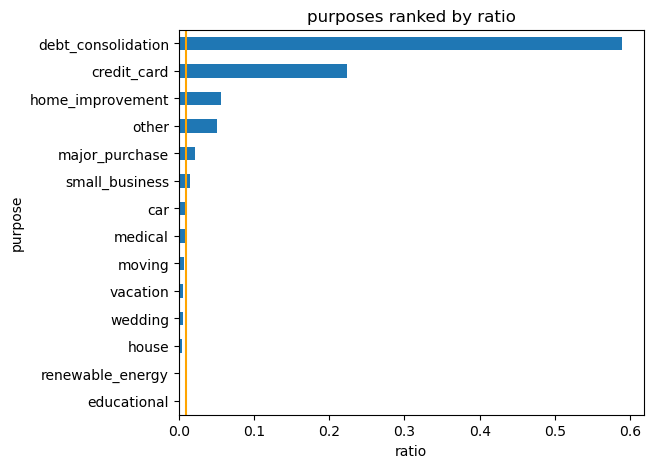

In [14]:
# Dataframe with ratios 
fig, ax = plt.subplots(1, figsize=(6,5))  # define figure and  axes
train_purpose_ratios = pd.crosstab(index=df_train.loc[:,'purpose'],
                                   columns='ratio', normalize='columns').sort_values(by='ratio')

# Plot ratios as horizontal bar graph
train_purpose_ratios.plot(kind='barh', legend=False, ax=ax)  

# improve plot
ax.set(xlabel='ratio', title='purposes ranked by ratio')

# draw 1% line
ax.vlines(x=0.01, ymin=-0.5, ymax=13.5, color ='orange');  

'dept_consolidation' is by far the most frequently given reason. [Debt consolidation](https://en.wikipedia.org/wiki/Debt_consolidation) is a form of debt refinancing that entails taking out one loan to pay off many others.

To make it easier for us, we summarize the categories that make up less than 1% (orange line) as 'other'. To do this, run the following code cell.

In [15]:
# create mask and change values
mask_purpose = df_train.loc[: , 'purpose'].isin(['educational', 'renewable_energy', 'house', 'wedding', 'vacation',
       'moving', 'medical'])  
df_train.loc[mask_purpose, 'purpose'] = 'other'

# check unique values
df_train['purpose'].unique()  

array(['debt_consolidation', 'credit_card', 'other', 'small_business',
       'home_improvement', 'major_purchase', 'car'], dtype=object)

We need to simplify the zip code by using the first digit of it.

In [16]:
# Define new column 1d_zip to get the first digit of zip code
df_train.loc[:,'1d_zip'] = df_train.loc[:,'zip_code'].str[0]
df_train.loc[:,'1d_zip'].nunique()

10

Now we come to the 'issue_d' column. Both the month and the year of the start of the loan are included here. We split these two pieces of information. The month is the first 3 characters of each value and the year is the last 4 characters. 

In [17]:
# Define column mounth and year
df_train.loc[:, 'month'] = df_train.loc[:, 'issue_d'].str[:3]
df_train.loc[:, 'year'] = pd.to_numeric(df_train.loc[:, 'issue_d'].str[-4:])

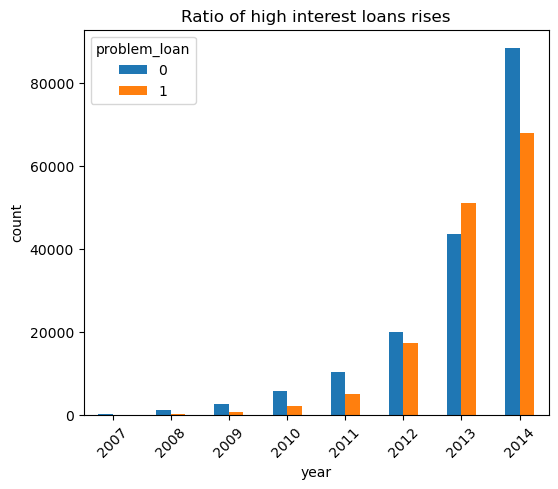

In [18]:
# create dataframe with ratios and plot
fig, ax = plt.subplots(1, figsize=(6,5)) 
pd.crosstab(index= df_train['year'], columns=df_train['problem_loan']).plot(kind='bar', ax=ax)

# improve plot
ax.xaxis.set_tick_params(rotation=45)  # rotate labels of xaxis
ax.set(ylabel='count', title='Ratio of high interest loans rises');

As we can see, number of loans have grown significantly in recent years (until 2014).

In [19]:
# Check emp_length, duration of the borrower's 
# employment at the start of the loan in years
df_train.loc[:, 'emp_length'].unique()

array(['9 years', '10+ years', '1 year', '2 years', '7 years', '8 years',
       '3 years', '< 1 year', nan, '4 years', '5 years', '6 years'],
      dtype=object)

In [20]:
# Extract numeric values of emp_length not emp_length_num
# Replace the '< 1' indications in 'emp_length' with '0'.
df_train.loc[:, 'emp_length'] = df_train.loc[:,'emp_length'].str.replace(pat=r'< 1', repl='0')
df_train.loc[:,'emp_length_num'] = df_train.loc[:,'emp_length'].str.extract(r'(\d+)', expand=False)

# Create new column unemployed
# Fill with 0 (person is employed)
df_train.loc[:, 'unemployed'] = 0 
# Select rows with missing job title and employment length
mask_unemployed = (df_train.loc[:, 'emp_length'].isna()) & (df_train.loc[:, 'emp_title'].isna())  
# Fill selected rows with 0 (person is not employed)
df_train.loc[mask_unemployed, 'unemployed'] = 1  

# Delete rows with employment length but missing job title
mask_na = (df_train.loc[:, 'emp_title'].isna()) & (~df_train.loc[:, 'emp_length'].isna())
df_train = df_train.drop(df_train.index[mask_na])

# Delete rows with job title but missing employment length
mask_na = (~df_train.loc[:, 'emp_title'].isna()) & (df_train.loc[:, 'emp_length'].isna())
df_train = df_train.drop(df_train.index[mask_na])

# Fill missing values in emp_length_num with -1 to prevent dropping them
df_train.loc[:, 'emp_length_num'] = df_train.loc[:, 'emp_length_num'].fillna(-1)
df_train.loc[:, 'emp_length_num'] = pd.to_numeric(df_train.loc[:, 'emp_length_num'])

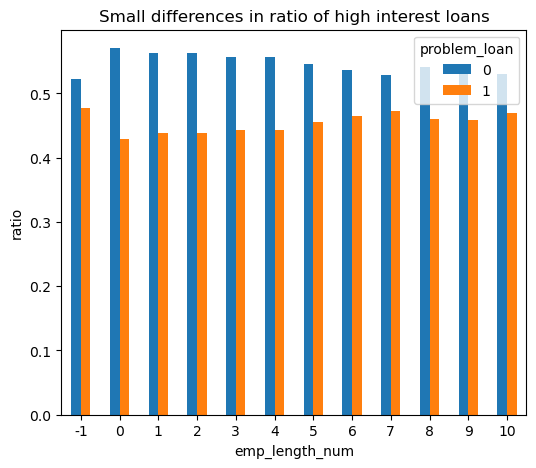

In [21]:
# Create dataframe with ratios and plot
fig, ax = plt.subplots(1, figsize=(6,5)) 
pd.crosstab(index= df_train['emp_length_num'], columns=df_train['problem_loan'], normalize='index').plot(kind='bar', ax=ax)

# Improve plot
# Rotate labels of xaxis
ax.xaxis.set_tick_params(rotation=0) 
ax.set(ylabel='ratio', title='Small differences in ratio of high interest loans');

It can be seen that the proportions of normal loans and problem loans are distributed relatively equally across all employment duration groups. The proportion of problem loans is slightly higher for people without a job title and without a period of employment (-1). Although normal loans tend to predominate, there are comparatively many problem loans,

Now let's look at how many unique values ​​the remaining object columns have. To do this, run the following cell:

In [22]:
# Number of unique vlaues
df_train.loc[:, ['term', 'emp_title', 'grade', 'sub_grade', 'home_ownership', 'verification_status']].nunique()

term                        2
emp_title              148458
grade                       7
sub_grade                  35
home_ownership              6
verification_status         3
dtype: int64

We see that 'emp_title' has a large number of unique values. Let's look at the first 20 values of this column.

In [23]:
# Print first 20 entries of 'emp_title'
df_train.loc[:,'emp_title'].head(20)

182824                                 president
72179                      Employment Consultant
81692                                  President
83169                                    Manager
256614    Memorial Sloan-Kettering Cancer Center
292380                              Hospitality 
199524                  Customer Account Manager
244763                          Verizon Business
176502                               project mgt
393610                    Union Pacific Railroad
414273                      Boehringer Ingelheim
52159                               Case Manager
320458                    Bender Transportation 
112007                                   Teacher
287755                                   teacher
222393                        Marketing Director
328498                  Green Bay Public Schools
244350                               wells fargo
106598                                       NaN
65718                             factory worker
Name: emp_title, dty

We see that, similar to the 'title' column, many entries have the same meaning and are just spelled differently. Presumably this column was also created by a free text field. A first indication of the irrelevance of 'emp_title'. Furthermore, it stands to reason that a job title doesn't carry much information (especially these days). Salary and length of employment are more important to the bank. So we decide to consider 'emp_title' irrelevant and remove it. We will do this later. Let's look at the other columns first.

In [24]:
# Check the column term: number of repayment installments in months (36 or 60)
print(df_train.loc[:, 'term'].unique())

# Replace the values ​​in 'term' with the number of months, i.e. 36 or 60
df_train.loc[:, 'term'] = df_train.loc[:, 'term'].replace({' 36 months': 36, ' 60 months': 60})
df_train.loc[:, 'term'].dtype

[' 36 months' ' 60 months']


dtype('int64')

The columns 'year' and 'month' should not be used in the model for the time being. Your superiors are convinced that seasonal effects play a minor role here. The growth in high-interest loans in recent years is mainly due to the marketing strategy. 

### Columns to drop
So we no longer need the columns ['id', 'issue_d', 'month', 'year', 'emp_title', 'emp_length', 'title', 'zip_code', 'int_rate'] any more. 

In [25]:
# Drop undesired columns
df_train = df_train.drop(['id', 'issue_d', 'month', 'year', 'emp_title', 'emp_length', 'title', 'zip_code', 'int_rate'], axis=1)

In [26]:
# Check the number of nan
df_train.isna().sum().sort_values(ascending=False)

percent_bc_gt_75       34496
total_bc_limit         31776
funded_amnt                0
term                       0
grade                      0
sub_grade                  0
home_ownership             0
annual_inc                 0
verification_status        0
purpose                    0
total_acc                  0
revol_bal                  0
problem_loan               0
1d_zip                     0
emp_length_num             0
unemployed                 0
dtype: int64

The columns 'percent_bc_gt_75' and 'total_bc_limit' still have many missing values. We don't know exactly where they come from. Both columns are about credit cards. It could be that these are mainly people who do not have credit cards. However, the number of missing values in both columns differs by almost 4000. So let's make it simple and remove the missing values

In [27]:
# Drop percent_bc_gt_75 and total_bc_limit
df_train = df_train.dropna()

In [28]:
# Define required data cleaning function

def data_cleaner(df):
    '''
    Function data_cleaner is responsible for train and validation data cleaning.
    Input:
        df: Train/validation dataframe
    output:
        df_cleaned: Cleaned train/validation dataframe   
    '''
    copy=df.copy()
    
    # 1-Create target column 'problem_loan'. loans with interest rate
    # of 15 or higher are assigned as problem_loa with 1 otherwise with 0.
    mask=(copy.loc[:,'int_rate'] > 14).astype('int8')
    copy.loc[:,'problem_loan']=mask
    
    # 2-Summarize the categories that make up less than 1%  of 'purpose' as 'other'.
    mask_purpose = copy.loc[: , 'purpose'].isin(['educational', 'renewable_energy', 'house', 'wedding', 'vacation',
       'moving', 'medical'])  
    copy.loc[mask_purpose, 'purpose'] = 'other'
    
    # 3-Get only first number of zip code as discussed in notebook
    copy.loc[:,'1d_zip'] = copy.loc[:,'zip_code'].str[0]
    
    # 4-Replace term with numbers:  36 months': 36, ' 60 months': 60
    copy.loc[:, 'term'] = copy.loc[:, 'term'].replace({' 36 months': 36, ' 60 months': 60})
    
    # 5-Extract numeric values of emp_length into emp_length_num
    copy.loc[:, 'emp_length'] = copy.loc[:,'emp_length'].str.replace(pat=r'< 1', repl='0')
    copy.loc[:,'emp_length_num'] = copy.loc[:,'emp_length'].str.extract(r'(\d+)', expand=False)
    
    # 6-Create new column unemployed
    # Fill with 0 (person is employed)
    copy.loc[:, 'unemployed'] = 0 
    # Select rows with missing job title and employment length
    mask_unemployed = (copy.loc[:, 'emp_length'].isna()) & (copy.loc[:, 'emp_title'].isna())  
    # Fill selected rows with 0 (person is not employed)
    copy.loc[mask_unemployed, 'unemployed'] = 1  

    # 7-Delete rows with employment length but missing job title
    mask_na = (copy.loc[:, 'emp_title'].isna()) & (~copy.loc[:, 'emp_length'].isna())
    copy = copy.drop(copy.index[mask_na])

    # 8-Delete rows with job title but missing employment length
    mask_na = (~copy.loc[:, 'emp_title'].isna()) & (copy.loc[:, 'emp_length'].isna())
    copy = copy.drop(copy.index[mask_na])

    # 9-Fill missing values in emp_length_num with -1 to prevent dropping them
    copy.loc[:, 'emp_length_num'] = copy.loc[:, 'emp_length_num'].fillna(-1)
    copy.loc[:, 'emp_length_num'] = pd.to_numeric(copy.loc[:, 'emp_length_num'])
    
    # 10-Drop irrelevant columns. We have not introduced `year` and `month`, thus we do not need to drop them
    copy = copy.drop(['id', 'issue_d', 'emp_title', 'emp_length', 'title', 'zip_code', 'int_rate'], axis=1)
    
    # 11-Drop missing values    
    df_cleaned = copy.dropna()
    
    return df_cleaned   

Apply data_cleaner on both train and validation data.

In [29]:
clean_loans_train = data_cleaner(df_train_org)
clean_loans_val = data_cleaner(df_val)

# Encode Categorical Features

In [30]:
# Import relevant transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define columns for OHE
columns=['grade', 'sub_grade', 'home_ownership', 'verification_status','1d_zip', 'purpose']

# Set up pipeline
ohe = OneHotEncoder(sparse=False)
encoder = ColumnTransformer([('OHE',ohe, columns)], remainder='passthrough')

# Fit encoder
encoder.fit(clean_loans_train)

# Restore column names for final DataFrames
ohe_names = encoder.named_transformers_['OHE'].get_feature_names(columns)
remaining_names = clean_loans_train.columns[encoder._remainder[2]]

# Apply encoding and create DataFrames
final_loans_train = pd.DataFrame(encoder.transform(clean_loans_train), columns = list(ohe_names) + list(remaining_names))
final_loans_val = pd.DataFrame(encoder.transform(clean_loans_val), columns = list(ohe_names) + list(remaining_names))

# Check shapes
print(final_loans_train.shape)
print(final_loans_val.shape)

(276878, 78)
(118609, 78)


In [31]:
# Split train and validation data into features and target
target_train = final_loans_train.loc[:, 'problem_loan']
features_train = final_loans_train.drop('problem_loan', axis=1)
target_val = final_loans_val.loc[:, 'problem_loan']
features_val = final_loans_val.drop('problem_loan', axis=1)

# Model Artificial Neural Networks


## Comparing Artificial Neuron versus Logistic Regression

Let's check the claim that logistic regression is the same model as an artificial neuron with the sigmoid activation function. We do this by comparing the results of both models directly with each other and at the same time creating a first baseline model.

Since we have a lot of binary features, features_train and features_val should first be scaled with the MinMaxScaler from sklearn.preprocessing.


In [33]:
# Scale train and validation data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_val_scaled = scaler.transform(features_val)

In [34]:
# Initiate Logistic Regression 
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(solver='lbfgs', max_iter=1000, C=1e42)
model_log.fit(features_train_scaled, target_train)

target_val_pred_log = model_log.predict(features_val_scaled)
target_val_pred_log

array([0., 0., 0., ..., 1., 0., 0.])

Since we have a almost balanced class distribution in our data, we can use accuracy as a good evaluation metric. Now import accuracy_score from sklearn.metrics and print the achieved accuracy on the validation set.

In [35]:
# Model accuracy score on validation data
from sklearn.metrics import accuracy_score
accuracy_score(target_val, target_val_pred_log)

0.9282263571904324

We use Tensorflow for artificial neuron. Tensorflow is currently the most extensive and widespread tool for the realization of models with artificial neurons. Probably the biggest advantage of tensorflow is that it includes the keras module as an API. Because of keras, creating models with artificial neurons is very easy, since the handling is very similar to sklearn.


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model type
model_an = Sequential()  
# Add one artificial neuron with sigmoid activtaion function
model_an.add(Dense(1, activation='sigmoid', input_dim=features_train_scaled.shape[1]))  
 # Compile the model
model_an.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy']) 


To train it, we can use the model_an.fit() method, analogous to sklearn.

In [37]:
# Fit the model
model_an.fit(features_train_scaled, target_train, epochs=5) 

Epoch 1/5
8653/8653 [==============================] - 17s 2ms/step - loss: 0.2078 - accuracy: 0.9144
Epoch 2/5
8653/8653 [==============================] - 16s 2ms/step - loss: 0.1366 - accuracy: 0.9270
Epoch 3/5
8653/8653 [==============================] - 16s 2ms/step - loss: 0.1353 - accuracy: 0.9271
Epoch 4/5
8653/8653 [==============================] - 15s 2ms/step - loss: 0.1353 - accuracy: 0.9269
Epoch 5/5
8653/8653 [==============================] - 16s 2ms/step - loss: 0.1352 - accuracy: 0.9271


Now let's compare our artificial neuron to logistic regression. For this we need the predictions of model_an on the validation data.

In [38]:
# Predict AN model
target_val_pred_an = model_an.predict(features_val_scaled)
target_val_pred_an

3707/3707 [==============================] - 5s 1ms/step


array([[0.00000007],
       [0.00000017],
       [0.00000015],
       ...,
       [0.9993108 ],
       [0.00000003],
       [0.00000003]], dtype=float32)

In [40]:
# Convert results into a 1-dimensional array
target_val_pred_an = target_val_pred_an.flatten()
target_val_pred_an

array([0.00000007, 0.00000017, 0.00000015, ..., 0.9993108 , 0.00000003,
       0.00000003], dtype=float32)

To calculate the accuracy, we now need to convert the predictions into the discrete values 0 and 1. To do this, we use the limit value 0.5, as in LogisticRegression. So replace all values less than 0.5 in target_val_pred_an with 0 and the remaining values with 1. Print out the result.

In [42]:
target_val_pred_an = target_val_pred_an > 0.5
accuracy_score(target_val, target_val_pred_an)

0.9281589086831522

tensorflow also provides us with a shortcut of the above steps. Instead of first generating the predictions, then converting the values to discrete values and finally calculating the accuracy, we can call the my_model.evaluate() method. This takes the validation data as input and outputs two values.

In [43]:
# Evaluate the model
model_an.evaluate(features_val_scaled, target_val)

3707/3707 [==============================] - 6s 2ms/step - loss: 0.1344 - accuracy: 0.9282


[0.13442808389663696, 0.9281588792800903]

The artificial neuron also achieves an almost identical accuracy score of approx. 92.7% (the second value) with the sigmoid activation function (slight deviations are always possible due to statistical fluctuations). So our assumption that an artificial neuron with sigmoid activation function is identical to logistic regression is correct - both theoretically and mathematically.

# Apply Artificial Neural Networks - Feedforward Neural Network (FNN)

A[ Feed Forward Neural Network](https://deepai.org/machine-learning-glossary-and-terms/feed-forward-neural-network) is an artificial neural network in which the connections between nodes does not form a cycle. The opposite of a feed forward neural network is a recurrent neural network, in which certain pathways are cycled. The feed forward model is the simplest form of neural network as information is only processed in one direction. While the data may pass through multiple hidden nodes, it always moves in one direction and never backwards.
![](https://images.deepai.org/django-summernote/2019-06-06/5c17d9c2-0ad4-474c-be8d-d6ae9b094e74.png)


# ... To be continued